# STATISTICS AND FINANCE PROJECT: EPEX GERMAN SPOT ANALYSIS
##### under supervision of Peter Tankov (tracher at ENSAE, CREST)
####  William Lambert, Loic Diridollou, Zacharie Bouhnik

# Data visualisation and first processing
<div class=warn>  
</div>

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import datetime
from datetime import datetime as dt
from datetime import timedelta as dta
%matplotlib inline
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt
from datetime import timedelta as dta

monthname = 'feb2014'
project_dir = '/Users/williamlambert/Desktop/statapp/' 

dfx = pd.read_csv(project_dir+monthname+'.csv')

#Clean null or single-valued data
dfx.drop('aa',axis=1,inplace=True)
dfx.drop('bb',axis=1,inplace=True)
dfx.drop('Smart Block Type',axis=1,inplace=True)
dfx.drop('Instrument Type',axis=1,inplace=True)
dfx.drop('Market',axis=1,inplace=True)
dfx.drop('Initial ID',axis=1,inplace=True)
dfx.drop('Parent ID',axis=1,inplace=True)
dfx.drop('Exclusive Group Id',axis=1,inplace=True)

print (list(dfx.columns))

dfx[' Start Validity Date'] = pd.to_datetime(dfx[' Start Validity Date'],format='%d/%m/%y %H:%M:%S.%f')
dfx['End Validity Date'] = pd.to_datetime(dfx['End Validity Date'],format='%d/%m/%y %H:%M:%S.%f')
dfx['Cancelling Date'] = pd.to_datetime(dfx['Cancelling Date'],format='%d/%m/%y %H:%M:%S.%f')


['Delivery Instrument', 'Delivery Date', ' Start Validity Date', 'End Validity Date', 'Cancelling Date', 'Area', 'Type', 'Order Archive Id', 'Order Id', 'Is Executed', 'Status', 'Side', 'Remaining Quantity', 'Account Type', 'User Name', 'Client Name', 'Price', 'Execution Price', 'Volume', 'Executed Volume']


In [90]:
import os
#To save figures and plots
def save_fig(CHAPTER_ID,fig_id, tight_layout=True):
    newpath=os.path.join(projet_dir, "images", CHAPTER_ID)
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    path = os.path.join(projet_dir, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id, 'in images/',CHAPTER_ID)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
#Add colors to notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./style.css", "r").read()
    return HTML(styles)
css_styling()

In [91]:
dfx.head()

,Delivery Instrument,Delivery Date,Start Validity Date,End Validity Date,Cancelling Date,Area,Type,Order Archive Id,Order Id,Is Executed,Status,Side,Remaining Quantity,Account Type,User Name,Client Name,Price,Execution Price,Volume,Executed Volume
0,01:00:00,2014-02-01,2014-01-31 15:02:35.690,2014-01-31 22:08:12.953,2014-01-31 22:08:12.953,DE-AMP,NaN,519650632,1019763107,0,True,B,NaN,P,EHWEXTRD006,EHWEST,15.2,NaN,30.0,0.0
1,01:00:00,2014-02-01,2014-01-31 15:02:35.850,2014-01-31 22:08:19.307,2014-01-31 22:08:19.307,DE-AMP,NaN,519650634,1019763131,0,True,S,NaN,P,EHWEXTRD006,EHWEST,40.2,NaN,30.0,0.0
2,01:00:00,2014-02-01,2014-01-31 15:03:22.173,2014-01-31 23:15:01.183,2014-01-31 23:15:01.183,DE-50Hz,NaN,519662794,1019763162,0,True,B,NaN,P,SWLEXTRD003,SWLEIP,16.0,NaN,10.0,0.0
3,01:00:00,2014-02-01,2014-01-31 15:03:22.347,2014-01-31 23:15:01.183,2014-01-31 23:15:01.183,DE-50Hz,NaN,519662796,1019763186,0,True,S,NaN,P,SWLEXTRD003,SWLEIP,46.0,NaN,10.0,0.0
4,01:00:00,2014-02-01,2014-01-31 15:03:22.617,2014-01-31 23:15:01.183,2014-01-31 23:15:01.183,DE-50Hz,NaN,519662798,1019763222,0,True,S,NaN,P,SWLEXTRD003,SWLEIP,66.0,NaN,15.0,0.0


In [347]:
#Check type of data
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356968 entries, 0 to 356967
Data columns (total 20 columns):
Delivery Instrument     356968 non-null object
Delivery Date           356968 non-null object
 Start Validity Date    356968 non-null datetime64[ns]
End Validity Date       356710 non-null datetime64[ns]
Cancelling Date         159958 non-null datetime64[ns]
Area                    356968 non-null object
Type                    1099 non-null object
Order Archive Id        356968 non-null int64
Order Id                356968 non-null int64
Is Executed             356968 non-null int64
Status                  356968 non-null bool
Side                    356968 non-null object
Remaining Quantity      102277 non-null float64
Account Type            356968 non-null object
User Name               356968 non-null object
Client Name             356968 non-null object
Price                   356968 non-null float64
Execution Price         167030 non-null float64
Volume                 

# Orderflow simulation : reproduces the exact orderbook mecanism of EPEX
<div class=warn>    
</div>

## - Preprocessing steps

##### Reduce amount of data by fixing one delivery date

In [93]:
# Delivery Instrument = 12h
flow=dfx[dfx['Delivery Instrument']=='12:00:00'].copy()

In [94]:
len(flow)

18622

##### Preprocessing -First Step: Dissociate different orders of Iceberg orders <br> (cf :  Brochure EPEX LOB Data / Research paper : Henry Martin et Scott Otterson)


In [95]:
print(flow['Order Id'].value_counts().values.max())
flow.loc[:,'Order Id'] *=50 #(50>=max occurencies of same order id=33)

33


In [96]:
flow.sort_values(by=['Order Id', ' Start Validity Date'],inplace=True)
iter=0
order_id,n=flow['Order Id'],len(flow['Order Id'])
for i in order_id:
    count=0
    iter+=1
    temp=flow.loc[flow['Order Id']==i].copy()
    L=temp.index
    if len(L)>1:
        for j in L:
            flow.loc[j,'Order Id']+=count
            if temp.loc[j,'Volume']==0.0:
                count+=1
                flow.drop([j],inplace=True)
    
    print('{}%'.format(np.round(100*iter/n,2)),end='\r')        

##### Reset sequencing by start date and index


In [97]:
flow['Index']=flow.index
flow.sort_values(by=[' Start Validity Date','Index'], inplace=True)

##### Associate each order with its respective time of delivery ( minus 30 minutes for market closure)


In [98]:
def func_time_close_market(row): #return market closure time for each order
    tim=row[' Start Validity Date']
    d,mth,y,h,m,s,ms=tim.day,tim.month,tim.year,tim.hour,tim.minute,tim.second,tim.microsecond
    if h<11 or (h==11 and m<=30) :
        close_market=pd.Timestamp(year=2014, month=mth,day=d,hour=11,minute=30,second=0,microsecond=887)
        
    else: #if time >=15h30  (no orders between 11h30:closure and 15h00:opening of day-ahead market)   
        if ((d==28 and mth==2) or (d==31 and mth==1)):
            dd=1
            mmth=mth+1
        else:
            dd=d+1
            mmth=mth
        
        close_market=pd.Timestamp(year=2014, month=mmth,day=dd,hour=11,minute=30,second=0,microsecond=887000)
    
    return close_market

In [99]:
flow['market_closure']=flow.apply(func_time_close_market,axis=1)

## Exemple of (rare) mistakes within the orderbook which shows the importance of simulation:

In [12]:
#This is the first 65 orders in the book
#=> The order 122852 does not match any opposite order, but is assumed as a transaction
flow.iloc[:50][[' Start Validity Date','Cancelling Date','End Validity Date','Is Executed','Side','Status','Order Id','Price','Volume','Execution Price','Executed Volume']]

,Start Validity Date,Cancelling Date,End Validity Date,Is Executed,Side,Status,Order Id,Price,Volume,Execution Price,Executed Volume
123198,2014-01-31 15:02:35.773,2014-02-01 06:05:14.367,2014-02-01 06:05:14.367,0,B,True,50988155900,20.06,9.8,NaN,0.0
123199,2014-01-31 15:02:35.917,2014-02-01 08:06:20.667,2014-02-01 08:06:20.667,0,S,True,50988157100,40.10,9.8,NaN,0.0
123200,2014-01-31 15:03:22.257,2014-02-01 10:15:01.130,2014-02-01 10:15:01.130,0,B,True,50988158650,16.00,10.0,NaN,0.0
123201,2014-01-31 15:03:22.413,2014-02-01 10:15:01.130,2014-02-01 10:15:01.130,0,S,True,50988159850,46.00,10.0,NaN,0.0
123202,2014-01-31 15:03:22.697,2014-02-01 10:15:01.130,2014-02-01 10:15:01.130,0,S,True,50988161650,66.00,15.0,NaN,0.0
123203,2014-01-31 15:05:40.097,2014-02-01 07:00:47.137,2014-02-01 07:00:47.137,0,B,True,50988163850,24.00,50.0,NaN,0.0
123204,2014-01-31 15:05:40.303,2014-01-31 16:04:43.517,2014-01-31 16:04:43.517,0,S,True,50988165050,42.00,50.0,NaN,0.0
123205,2014-01-31 15:07:37.320,2014-01-31 15:07:55.267,2014-01-31 15:07:55.267,0,B,True,50988167500,29.28,0.9,NaN,0.0
123206,2014-01-31 15:07:55.267,NaT,2014-01-31 23:02:42.697,0,B,True,50988168950,29.28,0.9,NaN,0.0
123207,2014-01-31 15:17:33.350,2014-01-31 15:18:31.313,2014-01-31 15:18:31.313,0,B,True,50988175150,16.00,30.0,NaN,0.0


## Orderflow simulation : see [Henry Martin et Scott Otterson research paper](https://www.researchgate.net/publication/326127890_German_Intraday_Electricity_Market_Analysis_and_Modeling_Based_on_the_Limit_Order_Book) 
<img src="orderflow2.png">
<div class=warn>    
</div>

In [13]:
size=len(flow)
size

17579

In [15]:
from time import sleep

CANCEL=pd.DataFrame(np.nan , index=[], columns=['date']) #to cancel orders
ob={'date':"", 'lob':pd.DataFrame(np.nan , index=[], 
                                    columns=['price','volume','side'])} # to store state of the orderbook 

EVENTS=pd.DataFrame(np.nan , index=[],  columns=['id','date','type','price','volume','side','bid','ask','midquote']) 
            #to save all market events indexed by date : cancellation, lob_order and transactions


TOSAVE=pd.DataFrame(np.nan,index=[], #to save state of the orderbook + useful statistics
                    columns=['id','date','buyIds','sellIds','buyVolumes','sellVolumes','buyPrices',
                             'sellPrices','buy_depth','sell_depth','bid','ask','is_transaction'])
market_closures=[]
#types
pd.to_datetime(CANCEL['date'],format='%d/%m/%y %H:%M:%S.%f')
pd.to_datetime(EVENTS['date'],format='%d/%m/%y %H:%M:%S.%f')
pd.to_datetime(TOSAVE['date'],format='%d/%m/%y %H:%M:%S.%f')
ob['lob']['side'] = ob['lob']['side'].astype(str)

#Beginning of simulation:
count=0 #progression bar
save_count=0 #to increment LOB state
anomaly=0 #to count spread anomalies
Tcount=0 #to increment events

for i in flow.index:
    count+=1
    if count%100==0: 
        sleep(0.5)
    print("Order flow simulation : {}% (prévoir environ 10 minutes)".format(np.round(100*count/size,3)), end='\r') #barre de progression de l'algorithme
    
    
        
    save_state=True # decide if we save LOB state for that order
    start=flow.loc[i,' Start Validity Date']
    end=flow.loc[i,' Start Validity Date']
    date=flow.loc[i,'Cancelling Date']
    id_=flow.loc[i,'Order Id']
    side=flow.loc[i,'Side']
    status=flow.loc[i,'Status']
    temp=flow.loc[flow['Order Id']==id_]
    m_closure=flow.loc[i, 'market_closure']
    
    if pd.notnull(date):#order has cancellation timestamp: can be either modified, desactivated or canceled
        
        # this is a desactivation action with start=cancellation time et end=reactivation time
        if status==False:
            save_state=False
            CANCEL.loc[id_]=start #we just cancel the order
                
        else: #this is a canceled order 
            
            if temp.index[-1]==i: #does not take into account modified orders
                CANCEL.loc[id_]=date #cancel the order
            
        
    else: #no cancellation timestamp: can be either market/limit orders, reborn order, or uncompleted order's modification
        
        if status==False: # this is an uncompleted order modification: with start=end_order_1, end=start_order_2
            CANCEL.loc[id_]=start #cancel previous order
            # increment orders left with same id
            for j in temp.index:
                if flow.loc[j, " Start Validity Date"]>start:
                    flow.loc[j, "Order Id"]+=1
            save_state=False
            
        else: #normal order
            if i != temp.index[0] : #this is a reborn order 
                save_state=False
            CANCEL.loc[id_]=temp.sort_values(by=[' Start Validity Date','Index']).iloc[-1]['End Validity Date']
            #to avoid orders to stay undefinitely in the book 
         
    if save_state==True: # this is a new order id 
          
        
        #1) Remove all previously canceled orders from orderbook
        
        for _id in CANCEL.index:
            
            if CANCEL.loc[_id]['date']<=start:
                if _id in ob['lob'].index:
                    p,v,s=ob['lob'].loc[_id,['price','volume','side']]
                    ob['lob'].drop([_id],inplace=True)
                    b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                    EVENTS.loc[Tcount]=[_id,start,'cancel',p,v,s,b,a,(a+b)/2]
                    Tcount+=1
                CANCEL.drop([_id],inplace=True)
                
        #2) Save state of lob
        
        if len(ob['lob'][ob['lob'].side=='S'])>0 and len(ob['lob'][ob['lob'].side=='B'])>0:
                        
             
            bqID=ob['lob'][ob['lob'].side=='B']
            aqID=ob['lob'][ob['lob'].side=='S']
            bqDEPTH=len(bqID.index)
            aqDEPTH=len(aqID.index)
            bqBID=bqID['price'].max()
            aqASK=aqID['price'].min()
            
            
            arrayBUY=bqID['price'].unique() #Distincts price  of buy side array
            arraySELL=aqID['price'].unique() #Distincts price  of sell side array
            id_PRICE_BUY=[i for i in range(len(arrayBUY))] 
            id_PRICE_SELL=[i for i in range(len(arraySELL))]
            
            bqPRICE=pd.Series(arrayBUY,index=id_PRICE_BUY).sort_values(ascending=False)
            aqPRICE=pd.Series(arraySELL,index=id_PRICE_SELL).sort_values(ascending=False)
            bqVOL=pd.Series([ ob['lob'][ (ob['lob'].price==px) & (ob['lob'].side=='B')]['volume'].sum() for px in bqPRICE],index=bqPRICE.index)
            aqVOL=pd.Series([ob['lob'][  (ob['lob'].price==px) & (ob['lob'].side=='S')]['volume'].sum() for px in aqPRICE],index=aqPRICE.index)
            dateSAVE=start
    
            TOSAVE.loc[i]=[id_,dateSAVE,bqID.index,aqID.index,bqVOL,aqVOL,bqPRICE,aqPRICE,bqDEPTH,aqDEPTH,bqBID,aqASK,False]
            if bqBID>aqASK:
                anomaly+=1
                
            save_count+=1
            
        
        
        #3) Update state lob if this order enables a transaction 
        
        price,volume=flow.loc[i]['Price'],flow.loc[i]['Volume']

        if side=='B':
            ob_sell=ob['lob'][ob['lob'].side=='S']
            if len(ob_sell)==0: 
                ob['lob'].loc[id_]=[price,volume,side] 
                ob['date']=str(start)
                
                
            else: #is this a market order?
                ask_id= ob_sell['price'].idxmin()
                ask_price=ob_sell['price'].min()
                         
                pile=ob_sell[ob_sell.price<=price].copy()
                pile.sort_values(by=['price','volume'],ascending=[True,False],inplace=True)
                ids=pile.index
                ask_volume=pile['volume'].sum()
                         
                if price>=ask_price:# transaction
                    
                    if i in TOSAVE.index:
                        TOSAVE.loc[i,'is_transaction']=True
                    
                    if volume>ask_volume:
                        
                        for u in ids:
                            ob['lob'].drop(u, inplace=True)
                            b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                            EVENTS.loc[Tcount]=[i,start,'transaction',pile.loc[u]['price'],pile.loc[u]['volume'],np.nan,b,a,(a+b)/2]
                            Tcount+=1
                        ob['lob'].loc[id_]=[price,volume-ask_volume,side]
                        b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                        EVENTS.loc[Tcount]=[i,start,'lob_order',price,volume-ask_volume,np.nan,b,a,(a+b)/2]
                        Tcount+=1
                        
                                            
                        
                        #generates trade at the ask
                        
                    elif volume==ask_volume:
                        for u in ids:
                            ob['lob'].drop(u, inplace=True)
                            b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                            EVENTS.loc[Tcount]=[i,start,'transaction',pile.loc[u]['price'],pile.loc[u]['volume'],np.nan,b,a,(a+b)/2]
                            Tcount+=1
                        
                    else:
                        save=volume
                        for y in pile.index:
                            v_y,p_y=pile.loc[y]['volume'],pile.loc[y]['price']
                            
                            if save == v_y:
                                ob['lob'].drop([y], inplace=True)
                                b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                                EVENTS.loc[Tcount]=[i,start,'transaction',p_y,v_y,np.nan,b,a,(a+b)/2]
                                Tcount+=1
                                break
                         
                            if save<v_y:
                                ob['lob'].loc[y,'volume']-=save
                                b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                                EVENTS.loc[Tcount]=[i,start,'transaction',p_y,save,np.nan,b,a,(a+b)/2]
                                Tcount+=1
                                break
            
                            if save>v_y:
                                save-=ob['lob'].loc[y,'volume']
                                ob['lob'].drop(y, inplace=True)
                                b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                                EVENTS.loc[Tcount]=[i,start,'transaction',p_y,v_y,np.nan,b,a,(a+b)/2]
                                Tcount+=1
                                pile.drop([y], inplace=True)
                                
                else:#add to lob as limit order
                    ob['lob'].loc[id_]=[price,volume,side]
                    ob['date']=str(start)
                    b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                    EVENTS.loc[Tcount]=[i,start,'lob_order',price,volume,side,b,a,(a+b)/2]
                    Tcount+=1
                    
                                    
        else: #side=='S'
            ob_buy=ob['lob'][ob['lob'].side=='B']
            if len(ob_buy)==0:
                ob['lob'].loc[id_]=[price,volume,side]
                ob['date']=str(start)
                
            else: #Is this a market order?
                bid_id= ob_buy['price'].idxmax()
                bid_price=ob_buy['price'].max()
                         
                pile=ob_buy[ob_buy.price>=price].copy()
                pile.sort_values(by=['price','volume'],ascending=[False,False],inplace=True)
                ids=pile.index
                bid_volume=pile['volume'].sum()
                         
                if price<=bid_price: #transaction
                    if i in TOSAVE.index:
                        TOSAVE.loc[i,'is_transaction']=True
                    
                    if volume>bid_volume:
                        for u in ids:
                            ob['lob'].drop(u, inplace=True)
                            b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                            EVENTS.loc[Tcount]=[i,start,'transaction',pile.loc[u]['price'],pile.loc[u]['volume'],np.nan,b,a,(a+b)/2]
                            Tcount+=1
                        ob['lob'].loc[id_]=[price,volume-bid_volume,side]
                        b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                        EVENTS.loc[Tcount]=[i,start,'lob_order',price,volume-bid_volume,np.nan,b,a,(a+b)/2]
                        Tcount+=1
                        #generates trade at the bid
                        
                    elif volume==bid_volume:
                        for u in ids:
                            ob['lob'].drop(u, inplace=True)
                            b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                            EVENTS.loc[Tcount]=[i,start,'transaction',pile.loc[u]['price'],pile.loc[u]['volume'],np.nan,b,a,(a+b)/2]
                            Tcount+=1
                    else:
                        save=volume
                        for y in pile.index:
                            v_y,p_y=pile.loc[y]['volume'],pile.loc[y]['price']
                            
                            if save==v_y:
                                ob['lob'].drop([y], inplace=True)
                                b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                                EVENTS.loc[Tcount]=[i,start,'transaction',p_y,v_y,np.nan,b,a,(a+b)/2]
                                Tcount+=1
                                break
                             
                            if save<v_y:
                                ob['lob'].loc[y,'volume']-=save
                                b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                                EVENTS.loc[Tcount]=[i,start,'transaction',p_y,save,np.nan,b,a,(a+b)/2]
                                Tcount+=1
                                break

                            if save>v_y:
                                save-=ob['lob'].loc[y,'volume']
                                ob['lob'].drop(y, inplace=True)
                                b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                                EVENTS.loc[Tcount]=[i,start,'transaction',p_y,v_y,np.nan,b,a,(a+b)/2]
                                Tcount+=1
                                pile.drop([y], inplace=True)
                            
                                
                else:#add to lob as limit order
                    ob['lob'].loc[id_]=[price,volume,side]
                    ob['date']=str(start)
                    b,a=ob['lob'][ob['lob'].side=='B'].price.max(),ob['lob'][ob['lob'].side=='S'].price.min()
                    EVENTS.loc[Tcount]=[i,start,'lob_order',price,volume,side,b,a,(a+b)/2]
                    Tcount+=1
                            
                                 
                             
                            

In [16]:
print("Erreurs dans le spread: ",anomaly) #check that everything is correct

Erreurs dans le spread:  0


## Tools to visualise lob state / debug 

ask= 25.0  volume=  [15.]
bid= 21.05  volume=  [50.]
sell side edges: [(25.0, 15.0), (25.5, 20.0)]
buy  side edges: [(21.05, 50.0), (21.0, 0.09999999999999432)]


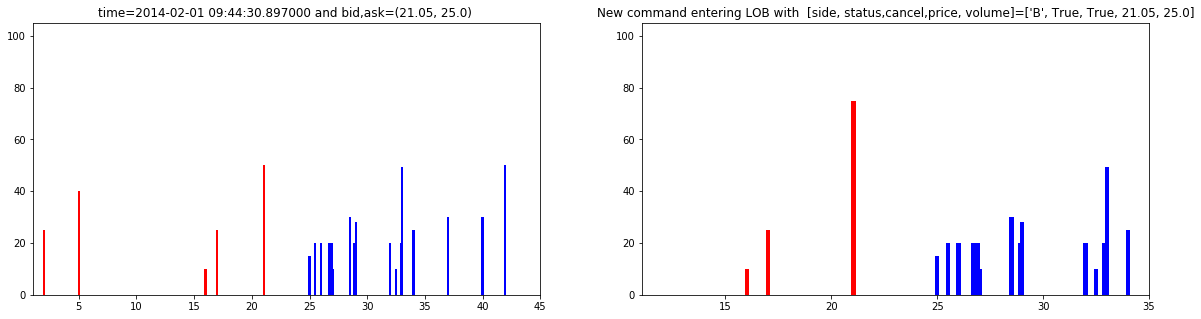

In [17]:
def plot_lob(_id_):
    temp=TOSAVE.loc[_id_:].copy()
    id_ =temp.index[0]
    next_id=temp.index[1]
    p,v,s=flow.loc[id_,'Price'],flow.loc[id_,'Volume'],flow.loc[id_,'Side']
    c,st=pd.isnull(flow.loc[id_,'Cancelling Date']),flow.loc[id_,'Status']
    
    fig=plt.figure()

    ax=fig.add_subplot(121) 
    
    cmd=TOSAVE.loc[id_]
    time=cmd['date']
    bid,ask=cmd.bid,cmd.ask
    
    print("ask=",ask," volume= ", cmd.sellVolumes[cmd.sellPrices==ask].values)
    print("bid=",bid," volume= ", cmd.buyVolumes[cmd.buyPrices==bid].values)
    print("sell side edges:",[(i,j) for (i,j) in zip(cmd.sellPrices.iloc[[-1,-2]].values,cmd.sellVolumes.iloc[[-1,-2]].values)])
    print("buy  side edges:",[(i,j) for (i,j) in zip(cmd.buyPrices.iloc[0:2].values,cmd.buyVolumes.iloc[0:2].values)])
    plt.bar(cmd['buyPrices'],cmd['buyVolumes'],width=0.2,color='red',label='Bid')
    plt.bar(cmd['sellPrices'],cmd['sellVolumes'],width=0.2,color='blue',label='Ask')
    plt.title('time={} and bid,ask={} '.format(str(time),(bid,ask)))
    plt.xlim([bid-20,ask+20])
    
    
    ax=fig.add_subplot(122) 
    cmd=TOSAVE.loc[next_id]
    plt.bar(cmd['buyPrices'],cmd['buyVolumes'],width=0.2,color='red',label='Bid')
    plt.bar(cmd['sellPrices'],cmd['sellVolumes'],width=0.2,color='blue',label='Ask')
    plt.title('New command entering LOB with  [side, status,cancel,price, volume]={}'.format([s,st,c,p,v]))
    plt.xlim([cmd['bid']-10,cmd['ask']+10])
    fig.set_figheight(5)
    fig.set_figwidth(20)
    return (id_,next_id)

t=123023
a,b=plot_lob(t)  

### Add useful variables : time_to_closure, spread, midquote, price_shift, depths ans volume_depths

In [18]:
def func_time_close_market(row): #return closure date of market for each order
    tim=row['date']
    d,mth,y,h,m,s,ms=tim.day,tim.month,tim.year,tim.hour,tim.minute,tim.second,tim.microsecond
    if h<11 or (h==11 and m<=30) :
        close_market=pd.Timestamp(year=2014, month=mth,day=d,hour=11,minute=30,second=0,microsecond=887)
        
    else: #if time >=15h30  (there's no orders between 11h30=close and 15h00=opening)   
        if ((d==28 and mth==2) or (d==31 and mth==1)):
            dd=1
            mmth=mth+1
        else:
            dd=d+1
            mmth=mth
        close_market=pd.Timestamp(year=2014, month=mmth,day=dd,hour=11,minute=30,second=0,microsecond=887000)
    
    return close_market


def func_time_to_closure(row): #return time (in minutes) until the market closure
    tim=row['date']
    close=row['market_closure']
    d1,mth1,y1,h1,m1,s1,ms1=tim.day,tim.month,tim.year,tim.hour,tim.minute,tim.second,tim.microsecond
    d2,mth2,y2,h2,m2,s2,ms2=close.day,close.month,close.year,close.hour,close.minute,close.second,close.microsecond
    if d1 not in [31,28]:
        if d2-d1>0:
            diff_min=((24-h1)*60)+(h2*60)+(m2-m1)
            diff_sec=diff_min*60 + s2-s1
        else:
            diff_min=((h2-h1)*60)+(m2-m1)
            diff_sec=diff_min*60+(s2-s1)
        return diff_sec
    else:
        if (d1==31 and d2==1) or (d1==28 and d2==1):
            return 60*((24-h1)*60-m1+(h2*60)+m2) + s2-s1
        else: return 60*(((h2-h1)*60)+(m2-m1)) + s2-s1
                
def func_tot_volume(row):
    buyV=row['buyVolumes'].sum()
    sellV=row['sellVolumes'].sum()
    return buyV+sellV  

def func_buyVolume(row):
    buyV=row['buyVolumes'].sum()
    return buyV

def func_sellVolume(row):
    sellV=row['sellVolumes'].sum()
    return sellV

def func_is_quote_revision(row):
    i=row.name
    return (TOSAVE.shift(-1).loc[i,'midquote']-TOSAVE.loc[i,'midquote'])!=0

def events_quote_revision(row): #return true if next command is a quote revision
    i=row.name
    if row.type!='cancel' and i>2:
        if EVENTS.loc[i-1,'midquote']!=row['midquote']:
            return True
    return False


In [19]:
TOSAVE['market_closure']=TOSAVE.apply(func_time_close_market,axis=1)
TOSAVE['time_to_closure']=TOSAVE.apply(func_time_to_closure,axis=1)
TOSAVE['totVolume']=TOSAVE.apply(func_tot_volume,axis=1)
TOSAVE['depth']=TOSAVE['buy_depth']+TOSAVE['sell_depth']
TOSAVE['midquote']=1/2*(TOSAVE['bid']+TOSAVE['ask'])
TOSAVE['is_quote_revision']=TOSAVE.apply(func_is_quote_revision,axis=1)
TOSAVE['spread']=TOSAVE['ask']-TOSAVE['bid']                                 
EVENTS['quote_revision']=EVENTS.apply(events_quote_revision,axis=1)
EVENTS['market_closure']=EVENTS.apply(func_time_close_market,axis=1)
EVENTS['time_to_closure']=EVENTS.apply(func_time_to_closure,axis=1)
EVENTS['spread']=EVENTS['ask']-EVENTS['bid']

In [343]:
def events_price_shift(row): #return price shift of buy transactions (if next orders are quote revisions,0 otherwise)
    i=row.name
    tim=row.date
    kmax=0
    if row.type=='transaction' and EVENTS.loc[i-1,'bid']==row.price:
        j=i+1
        k=i
        count=0
        d1,mth1,h1,m1,s1,ms1=tim.day,tim.month,tim.hour,tim.minute,tim.second,tim.microsecond
        
    
        while True:
            
            if j not in EVENTS.index:
                break
                
            tx=EVENTS.loc[j,'date']
            typ=EVENTS.loc[j,'type']
            isquote=EVENTS.loc[j,'quote_revision']
            d2,mth2=tx.day,tx.month
            h2,m2,s2,ms2=tx.hour,tx.minute,tx.second,tx.microsecond
            
            if (h2!=h1) or (d2!=d1) or (mth2!=mth1):
                break
                
            elif (m2!=m1):
                diff_time=(m2-m1)*60+(s2-s1)
            else:
                diff_time=s2-s1
                
            if diff_time>2:
                break
                
            if typ=='transaction':
                break
            k=j    
            j+=1
            count+=1
        
        if True in [EVENTS.loc[w,'quote_revision'] for w in range(i+1,k+1)]:
            pshift=EVENTS.loc[k,'midquote'] - EVENTS.loc[i,'midquote'] 
            if pshift!=0: return pshift
            return np.nan
        return np.nan
        #if EVENTS.loc[i+1,'type']!='transaction':
            #pshift=EVENTS.loc[i+1,'midquote'] - EVENTS.loc[i,'midquote'] 
            #if pshift!=0: return abs(pshift)
            #return 0
        #return np.nan
      
    return np.nan

EVENTS['price_shift']=EVENTS.apply(events_price_shift,axis=1)

### Really useful  : Function that get rid of noise, scale data, perform regression, display graphs

In [303]:
def binned_plot(dtf,col1,col2,mbins,title,reg=False,axis=None,mark='.',logY=False,exp=False,pol=False):
    dframe=dtf.sort_values(by=[col1])
    XX,YY=list(dframe[col1]),list(dframe[col2])
    #numbr of bins=m
    mbins+=1
    n=len(XX)
    bin_edges=[XX[0]]+[XX[int((i)*(n/mbins))] for i in range(1,mbins)]+[XX[n-1]]

    print('Data size=', len(XX))

    dic={}
    count=0
    jsave=0
    for i in dframe.index:
        x_=dframe.loc[i,col1]
        y_=dframe.loc[i,col2]
        b=False
        j=jsave
        
        while j <=(len(bin_edges)-1) and b==False:
            if x_ < bin_edges[j]:
                dic[j]=dic.get(j,[])+[y_]
                jsave=j
                b=True
            j+=1
            
    y_averaged=[]
    midpoints=[]

    for i in dic.keys():
        midpoints.append(np.log((bin_edges[i-1]+bin_edges[i])/2))
        if logY==True:
            y_averaged.append((np.log(np.mean(dic[i]))))
        else:
            y_averaged.append((np.mean(dic[i])))
    midpoints=np.array(midpoints)
    y_averaged=np.array(y_averaged)
    
     
    plt.plot(midpoints,y_averaged,mark,markeredgecolor='black',markeredgewidth=1.4,markerfacecolor='red')
    
    if reg==True:   
        x_reg,y_reg=midpoints.reshape(-1,1), y_averaged.reshape(-1,1)
        if exp==True:
            x_reg=np.exp(x_reg)
        if pol==True:
            x_reg2=np.power(x_reg,2)
            x_reg=np.concatenate([x_reg,x_reg2],axis=1)
        reg = LinearRegression().fit(x_reg,y_reg)
        b,a=reg.intercept_,reg.coef_
        rsqr=np.round(reg.score(x_reg, y_reg),4)
        title=title+'\n R-square={}'.format(rsqr)
        X_lin=np.linspace(min(midpoints),max(midpoints),1000)
        if exp==True:
            Y_lin=b+a[0][0]*np.exp(X_lin)
        elif pol==True:
            Y_lin=b+a[0][0]*(X_lin)+a[0][1]*(X_lin)**2
        else: Y_lin=b+a[0][0]*(X_lin)
        plt.plot(X_lin,Y_lin)
    
    plt.title(title)
    plt.grid()
    return dic

## Market Impact: Price shift :  see ['Master Curve for Price Impact Rosario N Mantegna'](https://www.academia.edu/12205968/Master_curve_for_price-impact_function)

- ###  Naive represenation of price shift

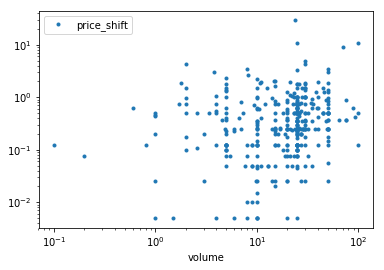

In [22]:
EVENTS[(EVENTS.price_shift!=0) ].plot(x='volume',y='price_shift',style='.',logx=True,logy=True)

- ### Let's bin the volume and consider the average  price_shift

Data size= 540


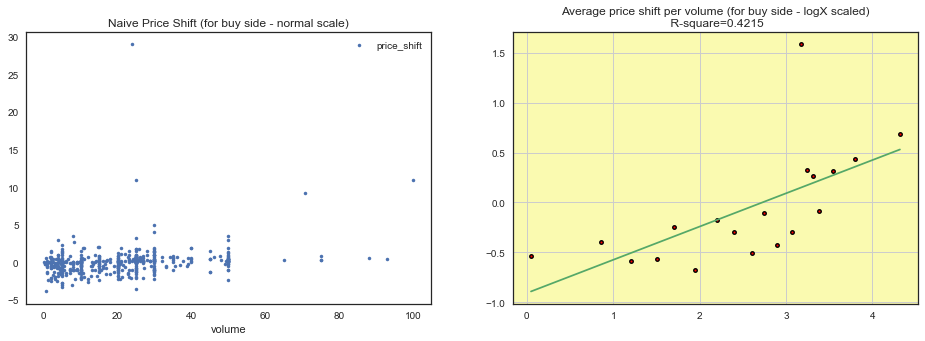

In [344]:
temp=EVENTS[pd.notnull(EVENTS.price_shift) ]

fig, axes = plt.subplots(nrows=1, ncols=2)

EVENTS[(EVENTS.price_shift!=0) ].plot(x='volume',y='price_shift',title='Naive Price Shift (for buy side - normal scale)',style='.',logx=False,logy=False,ax=axes[0])

ax=axes[1]
#bin plot with regression
dic=binned_plot(temp,'volume','price_shift',27,'Average price shift per volume (for buy side - logX scaled)',logY=False,reg=True)
fig.set_figheight(5)
fig.set_figwidth(16)
ax.set_facecolor('#fafab0')


## Linear regression between time left until market closure (time_to_closure) and orderbook depth (depth)

### Linear regression for one day:

Rsquared= 0.9343467382964129   Volume= -0.02 *time_to_closure + 1767.0


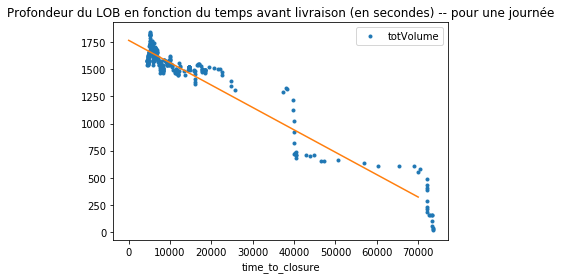

In [24]:
index1=[i for i in TOSAVE.index if (TOSAVE.loc[i,'date'].day in[1,31]) and ( TOSAVE.loc[i,'date'].month in [1,2] )]

temp=TOSAVE.loc[index1]
#for min index2=[i for i in temp.index if ((temp.loc[i,'date'].day==31)or( temp.loc[i,'date'].day==1 and temp.loc[i,'date'].hour<=11) )]
#for sec 
index2=[i for i in temp.index if ((temp.loc[i,'date'].day==31)or( temp.loc[i,'date'].day==1 and temp.loc[i,'date'].hour<=11) )]
temp2=temp.loc[index2]


X=temp2['time_to_closure'].values.reshape(-1,1)
Y=temp2['totVolume'].values.reshape(-1,1)
reg = LinearRegression().fit(X, Y)
a,b=reg.intercept_,reg.coef_

temp2.plot(x='time_to_closure',y='totVolume',style='.',title='Profondeur du LOB en fonction du temps avant livraison (en secondes) -- pour une journée')

Z1=np.linspace(0,70000,1000)
Z2=a+b*Z1.reshape(-1,1)
plt.plot(Z1,Z2)


print("Rsquared=",reg.score(X, Y),'  Volume=',np.round(b[0][0],2),'*time_to_closure +',np.round(a[0]))

### Same regression for one month using binned_plot:

In [25]:
TOSAVE.head()

,id,date,buyIds,sellIds,buyVolumes,sellVolumes,buyPrices,sellPrices,buy_depth,sell_depth,bid,ask,is_transaction,market_closure,time_to_closure,totVolume,depth,midquote,is_quote_revision,spread
123200,5.098816e+10,2014-01-31 15:03:22.257,"Int64Index([50988155900], dtype='int64')","Int64Index([50988157100], dtype='int64')",0 9.8 dtype: float64,0 9.8 dtype: float64,0 20.06 dtype: float64,0 40.1 dtype: float64,1.0,1.0,20.06,40.1,0,2014-02-01 11:30:00.887,73598,19.6,2.0,30.08,False,20.04
123201,5.098816e+10,2014-01-31 15:03:22.413,"Int64Index([50988155900, 50988158650], dtype='...","Int64Index([50988157100], dtype='int64')",0 9.8 1 10.0 dtype: float64,0 9.8 dtype: float64,0 20.06 1 16.00 dtype: float64,0 40.1 dtype: float64,2.0,1.0,20.06,40.1,0,2014-02-01 11:30:00.887,73598,29.6,3.0,30.08,False,20.04
123202,5.098816e+10,2014-01-31 15:03:22.697,"Int64Index([50988155900, 50988158650], dtype='...","Int64Index([50988157100, 50988159850], dtype='...",0 9.8 1 10.0 dtype: float64,1 10.0 0 9.8 dtype: float64,0 20.06 1 16.00 dtype: float64,1 46.0 0 40.1 dtype: float64,2.0,2.0,20.06,40.1,0,2014-02-01 11:30:00.887,73598,39.6,4.0,30.08,False,20.04
123203,5.098816e+10,2014-01-31 15:05:40.097,"Int64Index([50988155900, 50988158650], dtype='...","Int64Index([50988157100, 50988159850, 50988161...",0 9.8 1 10.0 dtype: float64,2 15.0 1 10.0 0 9.8 dtype: float64,0 20.06 1 16.00 dtype: float64,2 66.0 1 46.0 0 40.1 dtype: float64,2.0,3.0,20.06,40.1,0,2014-02-01 11:30:00.887,73460,54.6,5.0,30.08,True,20.04
123204,5.098817e+10,2014-01-31 15:05:40.303,"Int64Index([50988155900, 50988158650, 50988163...","Int64Index([50988157100, 50988159850, 50988161...",2 50.0 0 9.8 1 10.0 dtype: float64,2 15.0 1 10.0 0 9.8 dtype: float64,2 24.00 0 20.06 1 16.00 dtype: float64,2 66.0 1 46.0 0 40.1 dtype: float64,3.0,3.0,24.00,40.1,0,2014-02-01 11:30:00.887,73460,104.6,6.0,32.05,False,16.10


In [26]:
TOSAVE['is_transaction']= TOSAVE['is_transaction'].astype('float64')
TOSAVE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14620 entries, 123200 to 141445
Data columns (total 20 columns):
id                   14620 non-null float64
date                 14620 non-null datetime64[ns]
buyIds               14620 non-null object
sellIds              14620 non-null object
buyVolumes           14620 non-null object
sellVolumes          14620 non-null object
buyPrices            14620 non-null object
sellPrices           14620 non-null object
buy_depth            14620 non-null float64
sell_depth           14620 non-null float64
bid                  14620 non-null float64
ask                  14620 non-null float64
is_transaction       14620 non-null float64
market_closure       14620 non-null datetime64[ns]
time_to_closure      14620 non-null int64
totVolume            14620 non-null float64
depth                14620 non-null float64
midquote             14620 non-null float64
is_quote_revision    14620 non-null bool
spread               14620 non-null float64
dt

Rsquared= 0.3648002015948315   totVolume= 1579.664223929811 + -0.02 *time_to_closure 


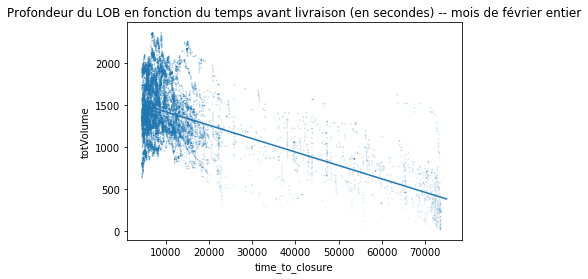

In [27]:
X=TOSAVE['time_to_closure'].values.reshape(-1,1)
Y=TOSAVE['totVolume'].values.reshape(-1,1)
reg = LinearRegression().fit(X, Y)
b,a=reg.intercept_,reg.coef_

TOSAVE.plot(kind='scatter',x='time_to_closure',y='totVolume',alpha=0.3, style='.', s=TOSAVE['buy_depth']/100,
            title='Profondeur du LOB en fonction du temps avant livraison (en secondes) -- mois de février entier'
            )

Z1=np.linspace(5000,75000,1250)
Z2=b+a*Z1.reshape(-1,1)
plt.plot(Z1,Z2)

print("Rsquared=",reg.score(X, Y),'  totVolume=',b[0],'+',np.round(a[0][0],2),'*time_to_closure ')

Let's binning to erase noise

Data size= 14620  There is 36 point per bins and 399 bins



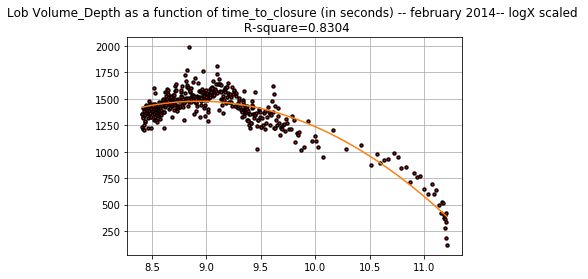

In [87]:
binned_plot(TOSAVE,'time_to_closure','totVolume',400,'Lob Volume_Depth as a function of time_to_closure (in seconds) -- february 2014-- logX scaled ',reg=True,pol=True)
print('')

In [62]:
EVENTS

,id,date,type,price,volume,side,bid,ask,midquote,quote_revision,market_closure,time_to_closure,spread,price_shift
0,1.231990e+05,2014-01-31 15:02:35.917,lob_order,40.10,9.8,S,20.06,40.1,30.080,False,2014-02-01 11:30:00.887000,73645,20.04,NaN
1,1.232000e+05,2014-01-31 15:03:22.257,lob_order,16.00,10.0,B,20.06,40.1,30.080,False,2014-02-01 11:30:00.887000,73598,20.04,NaN
2,1.232010e+05,2014-01-31 15:03:22.413,lob_order,46.00,10.0,S,20.06,40.1,30.080,False,2014-02-01 11:30:00.887000,73598,20.04,NaN
3,1.232020e+05,2014-01-31 15:03:22.697,lob_order,66.00,15.0,S,20.06,40.1,30.080,False,2014-02-01 11:30:00.887000,73598,20.04,NaN
4,1.232030e+05,2014-01-31 15:05:40.097,lob_order,24.00,50.0,B,24.00,40.1,32.050,True,2014-02-01 11:30:00.887000,73460,16.10,NaN
5,1.232040e+05,2014-01-31 15:05:40.303,lob_order,42.00,50.0,S,24.00,40.1,32.050,False,2014-02-01 11:30:00.887000,73460,16.10,NaN
6,1.232050e+05,2014-01-31 15:07:37.320,lob_order,29.28,0.9,B,29.28,40.1,34.690,True,2014-02-01 11:30:00.887000,73343,10.82,NaN
7,5.098817e+10,2014-01-31 15:07:55.267,cancel,29.28,0.9,B,24.00,40.1,32.050,False,2014-02-01 11:30:00.887000,73325,16.10,NaN
8,1.232060e+05,2014-01-31 15:07:55.267,lob_order,29.28,0.9,B,29.28,40.1,34.690,True,2014-02-01 11:30:00.887000,73325,10.82,NaN
9,1.232070e+05,2014-01-31 15:17:33.350,lob_order,16.00,30.0,B,29.28,40.1,34.690,False,2014-02-01 11:30:00.887000,72747,10.82,NaN


### Bid Ask Distribution

(0, 20)

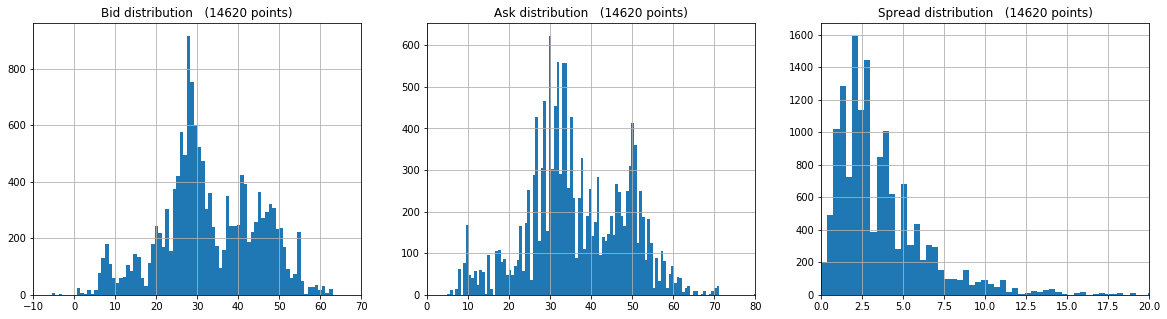

In [29]:
fig=plt.figure()
ax1=fig.add_subplot(131) 
TOSAVE['bid'].hist(bins=300,ax=ax1)
plt.xlim(-10,70)
plt.title('Bid distribution   ({} points)'.format(len(TOSAVE)))
ax2=fig.add_subplot(132) 
plt.title('Ask distribution   ({} points)'.format(len(TOSAVE)))
TOSAVE['ask'].hist(bins=300,ax=ax2)
plt.xlim(0,80)
ax3=fig.add_subplot(133) 
plt.title('Spread distribution   ({} points)'.format(len(TOSAVE)))
TOSAVE['spread'].hist(bins=1000,ax=ax3)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.xlim(0,20)

## Proportion of transaction events, by hour

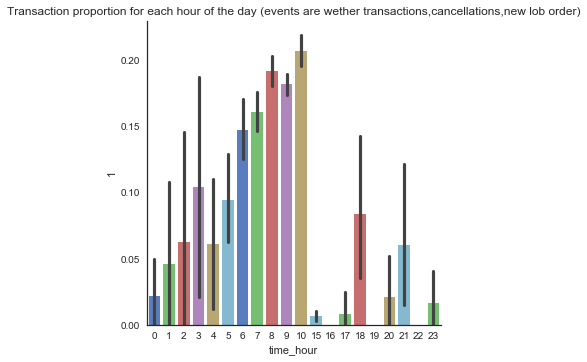

In [300]:
import warnings; warnings.simplefilter('ignore')
EVENTS_temp=pd.get_dummies(EVENTS,columns=['type'])
sns.set(style='white', context='notebook', palette='deep')
g = sns.factorplot(x="time_hour",y="type_transaction",kind="bar",data=EVENTS_temp,palette="muted",size=5)
g = g.set_ylabels(1)

plt.title("Transaction proportion for each hour of the day (events are wether transactions,cancellations,new lob order)")
plt.show()

## Correlation Matrix

Text(0.5,1,'Correlation matrix of EVENTS variables')

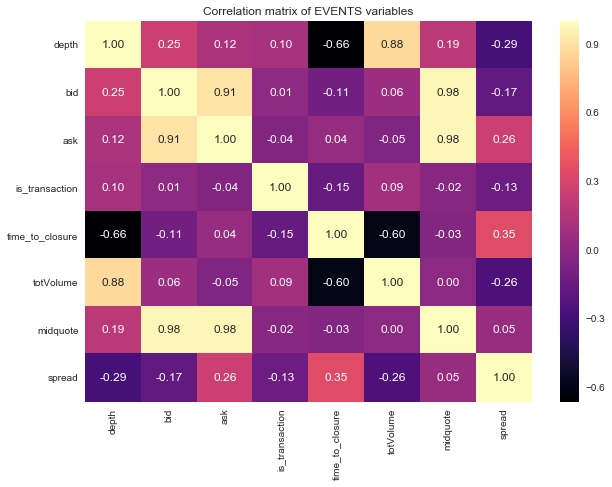

In [346]:
numeric_features=['depth','bid','ask','is_transaction','time_to_closure', 'totVolume', 'midquote', 'spread']
fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
g = sns.heatmap(TOSAVE[numeric_features].corr(),annot=True, fmt = ".2f", cmap = "magma",ax=ax)
plt.title('Correlation matrix of EVENTS variables')


## Spread evolution during trading session see [Clara Balardy : Empirical Analysis](http://www.ceem-dauphine.org/assets/dropbox/0918-CEEM_Working_Paper_35_Clara_BALARDY.pdf)

Data size= 14620  There is 7 point per bins and 1999 bins
Data size= 14620  There is 14 point per bins and 999 bins



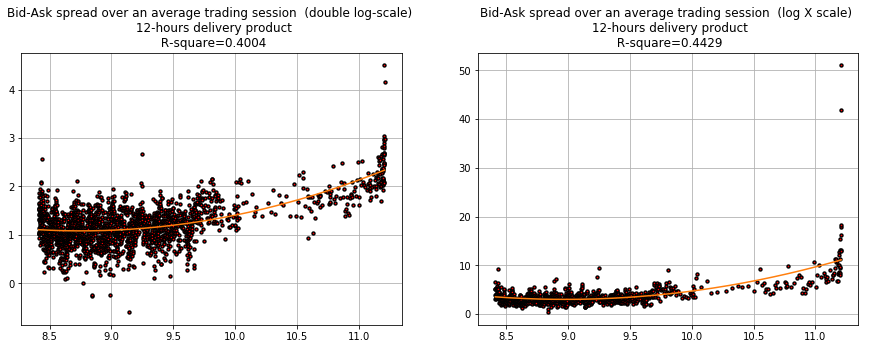

In [30]:
END_TRADE=TOSAVE[TOSAVE.time_to_closure<70000] #from midnight to 10:30 a.m
fig=plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
ax=fig.add_subplot(121) 
binned_plot(TOSAVE,'time_to_closure','spread',2000,'Bid-Ask spread over an average trading session  (double log-scale) \n 12-hours delivery product',logY=True,reg=True,pol=True)

ax=fig.add_subplot(122)
binned_plot(TOSAVE,'time_to_closure','spread',1000,'Bid-Ask spread over an average trading session  (log X scale) \n 12-hours delivery product',logY=False,reg=True,pol=True)
print('')

## Midquote plots: Estimation d'un Modèle brownien avec dérive

Data size= 490
Data size= 345


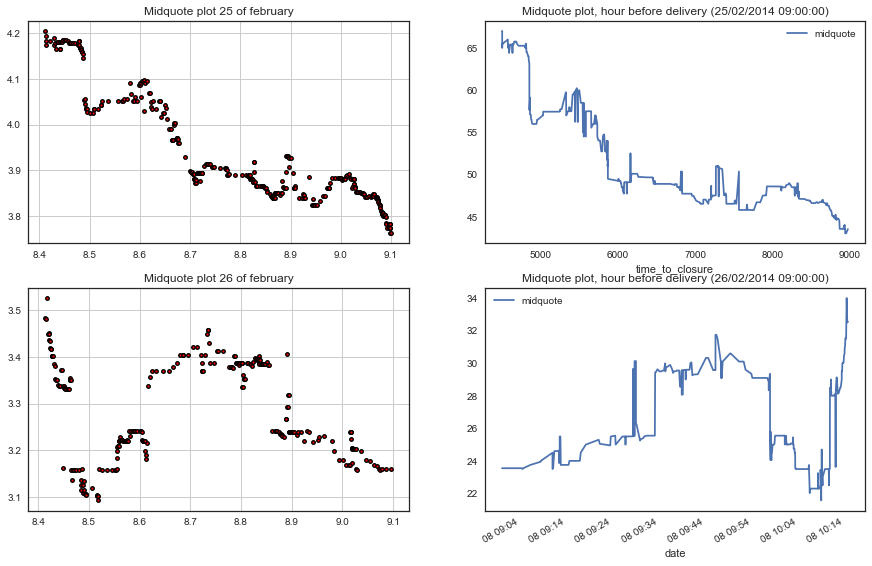

In [345]:
#Look at midquote at the end of the day ()
day_to_look_at=[18,8]

fig=plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)

ax=fig.add_subplot(221) 
index1=[i for i in TOSAVE.index if (TOSAVE.loc[i,'date'].day==day_to_look_at[0]) and ( TOSAVE.loc[i,'date'].month in [1,2] )]
binned_plot(TOSAVE.loc[index1][TOSAVE['time_to_closure']<9000],'time_to_closure','midquote',400,'Midquote plot 25 of february',logY=True,reg=False,pol=True)
    


ax=fig.add_subplot(222)
index1=[i for i in TOSAVE.index if (TOSAVE.loc[i,'date'].day==day_to_look_at[0]) and ( TOSAVE.loc[i,'date'].month in [1,2] )]
temp=TOSAVE.loc[index1][TOSAVE['time_to_closure']<9000]
temp.plot(x='time_to_closure',y='midquote',ax=ax,title='Midquote plot, hour before delivery (25/02/2014 09:00:00)')

ax=fig.add_subplot(223)
index1=[i for i in TOSAVE.index if (TOSAVE.loc[i,'date'].day==day_to_look_at[1]) and ( TOSAVE.loc[i,'date'].month in [1,2] )]
binned_plot(TOSAVE.loc[index1][TOSAVE['time_to_closure']<9000],'time_to_closure','midquote',400,'Midquote plot 26 of february',logY=True,reg=False,pol=True)

ax=fig.add_subplot(224)
index1=[i for i in TOSAVE.index if (TOSAVE.loc[i,'date'].day==day_to_look_at[1]) and ( TOSAVE.loc[i,'date'].month in [1,2] )]
temp=TOSAVE.loc[index1][TOSAVE['time_to_closure']<9000]
temp.plot(x='date',y='midquote',ax=ax,title='Midquote plot, hour before delivery (26/02/2014 09:00:00)')